Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [3]:
NAME = "Breno de Castro Pimenta"
COLLABORATORS = ""

---

# Exercício Prático 4: Uso da Decomposição LU

Neste exercício vamos estudar o ganho de desempenho ao se utilizar a decomposição LU para resolver diversos sistemas do tipo $Ax_1=b_1, Ax_2=b_2, \ldots Ax_k=b_k$.

### Apresentação da Decomposição LU e da Eliminação de Gauss

Na aula do dia 11/04 vimos que a decomposição $A = LU$ consiste em decompor uma matriz $A$ no produto de uma matriz triangular inferior $L$ por uma matriz triangular superior $U$. Em particular, observamos que os multiplicadores da eliminação de Gauss são utilizados para "preencher" a matriz $L$.

**Por simplicidade, vamos assumir que todas as matrizes são quadradas.**

A implementação da decomposição LU é apresentada abaixo.

In [4]:
import numpy as np
def LU(A):
    U = np.copy(A)
    m, n = A.shape
    L = np.zeros((n,n))
    for j in range(n-1):
        for i in range(j+1,n):
            L[i,j] = U[i,j]/U[j,j]
            U[i,j+1:n] = U[i,j+1:n]-L[i,j] * U[j,j+1:n]
    L = L + np.eye(n)
    return L, np.triu(U)

Note que ela é muito semelhante à implementação da Eliminação de Gauss, apresentada a seguir. Uma diferença importante é que a Eliminação de Gauss também recebe como parâmetro um vetor b.

In [5]:
def eliminacaoDeGauss(A,b):
    U=A.copy()
    d=b.copy()
    n = len(b)
    for j in range(n-1):
        r = 1.0/U[j,j]
        for i in range(j+1,n):
            m = U[i,j]*r
            U[i,j+1:n] = U[i,j+1:n]-m*U[j,j+1:n]
            d[i] = d[i]-m*d[j]
    return np.triu(U), d

A solução de um sistema do tipo $Ax=b$ a partir da decomposição LU de $A$ é realizada em duas etapas.
* Etapa 1: solução do sistema triangular $Ly=b$
* Etapa 2: solução do sistema triangular $Ux=y$.

O exemplo a seguir mostra a construção de uma matriz $A$ $n \times n$, um vetor $b$ de tamanho $n$ e a solução do sistema $Ax=b$ usando a função LU definida anteriormente.

In [6]:
from scipy.linalg import solve_triangular
 
n = 3
A = np.random.random((n,n))
b = np.random.random(n)
#A = np.array([[1,-3,2],[-2,8,-1],[4,-6,5]])
#b = np.array([11,-15,29])
print('A =',A)
print('b =',b)

A = [[0.25333058 0.1358616  0.96166724]
 [0.56873135 0.10919754 0.48373951]
 [0.28036964 0.07115853 0.42850182]]
b = [0.15869598 0.7924283  0.83085486]


In [7]:
L, U = LU(A)
y = solve_triangular(L,b,lower=True)
x = solve_triangular(U,y)
print('LU: x =',x)

LU: x = [  10.89452966 -100.23353305   11.45579916]


O exemplo a seguir mostra como resolver o mesmo sistema utilizando a Eliminação de Gauss.

In [8]:
U, d = eliminacaoDeGauss(A,b)
x = solve_triangular(U,d)
print('Eliminação de Gauss: x =',x)

Eliminação de Gauss: x = [  10.89452966 -100.23353305   11.45579916]


Como era de se esperar, a solução é exatamente a mesma. Usando a função mágica %timeit, iremos comparar o tempo necessário para resolver o sistema $Ax=b$ através de cada um dos métodos.

In [9]:
time_info = %timeit -r 3 -n 1000 -q -o L,U = LU(A)
print(time_info.average)

7.862683333332636e-05


In [10]:
time_info = %timeit -r 3 -n 1000 -q -o y = solve_triangular(L,b,lower=True); x = solve_triangular(U,y)
print(time_info.average)

0.00011127996666666225


In [11]:
time_info = %timeit -r 3 -n 1000 -q -o U, d = eliminacaoDeGauss(A,b)
print(time_info.average)

4.4438099999988864e-05


In [12]:
time_info = %timeit -r 3 -n 1000 -q -o x = solve_triangular(U,d)
print(time_info.average)

5.886356666666377e-05


Como pode-se observar, o tempo para executar ```LU``` e ```eliminacaoDeGauss``` é praticamente o mesmo, mas o LU requer a solução de dois sistemas triangulares, enquanto Gauss requer apenas um. O objetivo deste trabalho é mostrar que, para sistemas grandes, quando a fatoração LU é reaproveitada para resolver uma sequência de sistemas $Ax_1=b_1, \ldots, Ax_k=b_k$, a solução via LU acaba sendo mais rápida que via Eliminação de Gauss.

## Questão 1: Gerando os sistemas

Nesta questão você deve gerar as matrizes $A_{n \times n}$ e os vetores $b_1, \ldots, b_k$ usando a função ```numpy.random.random```. Os vetores $b$ devem ficar armazenados em uma matriz $B_{n \times k}$. Inicialmente faremos $n=10$ e $k=10$.

In [29]:
def geraMatrizes(n,k):
    A = np.random.random((n,n))
    B = np.random.random((n,k))
    return A,B

In [87]:
A,B = geraMatrizes(10,10)
C,D = geraMatrizes(10,10)
assert np.all(A != C) and np.all(B != D)

## Questão 2: Medindo o tempo para a resolução dos sistemas

Escreva uma função ```resolveViaGauss``` que resolve todos os sistemas $Ax_1=b_1, \ldots, Ax_k=b_k$ por Eliminação de Gauss e outra função ```resolveViaLU``` que os resolve por $LU$. As soluções $x_1, \ldots, x_k$ devem ser retornadas como colunas de uma matriz $X$.

In [95]:
def resolveViaGauss(A,B):
    n,k = B.shape
    X = np.zeros((n,k))
    # YOUR CODE HERE

    for linear_system in range(k):
        A_gauss, b_gauss = eliminacaoDeGauss(A, B[:, linear_system])
        X[:,linear_system] = solve_triangular(A_gauss,b_gauss)
    
    
    #raise NotImplementedError()
    return X

In [93]:
def resolveViaLU(A,B):
    n,k = B.shape
    X = np.zeros((n,k))
    # YOUR CODE HERE
    L, U = LU(A)
    for linear_system in range(k):
        y = solve_triangular(L,B[:,linear_system],lower=True)
        X[:,linear_system] = solve_triangular(U,y)
    
    
    #raise NotImplementedError()
    return X

In [96]:
X = resolveViaGauss(A,B)
n,k = B.shape
for j in range(k):
    assert np.allclose(A@X[:,j],B[:,j])

In [97]:
X = resolveViaLU(A,B)
n,k = B.shape
for j in range(k):
    assert np.allclose(A@X[:,j],B[:,j])

## Questão 3: Comparando o tempo

Agora vamos usar a função mágica ```%timeit``` para comparar o tempo gasto por cada uma das funções. Abaixo segue um exemplo para $n=10$ e $k=10$. Por simplicidade, vamos sempre fazer $n=k$.  

In [99]:
n = k = 10
A,B = geraMatrizes(n,k)
time_info = %timeit -r 3 -n 3 -q -o  resolveViaGauss(A,B)
print('Tempo médio para resolver via Gauss:',time_info.average)
time_info = %timeit -r 3 -n 3 -q -o  resolveViaLU(A,B)
print('Tempo médio para resolver via LU:',time_info.average)

Tempo médio para resolver via Gauss: 0.009399344442903789
Tempo médio para resolver via LU: 0.0033270555593642513


Na célula abaixo você deve criar um laço variando a ordem da matriz $A$ $n \in \{10,20,\ldots,100\}$ que irá armazenar o tempo médio de execução em função de $n$, para cada método de solução. Lembrando que $k=n$. Os resultados obtidos serão usados para plotar um gráfico com duas curvas usando a célula (somente leitura) seguinte.

In [108]:

nvals = np.arange(1,11)*10

# YOUR CODE HERE
times_Gauss = np.zeros(10)
times_LU = np.zeros(10)

for i in range(10):
    A,B = geraMatrizes(nvals[i],nvals[i])
#   GAUSS
    time_info = %timeit -r 3 -n 3 -q -o  resolveViaGauss(A,B)
    times_Gauss[i] = time_info.average
#   LU
    time_info = %timeit -r 3 -n 3 -q -o  resolveViaLU(A,B)
    times_LU[i] = time_info.average    

# raise NotImplementedError()

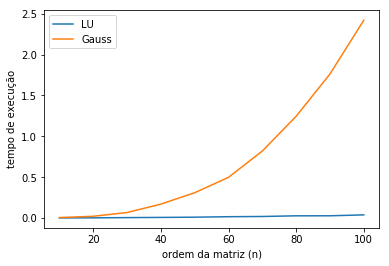

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(nvals,times_LU,label='LU')
plt.plot(nvals,times_Gauss,label='Gauss')
plt.xlabel('ordem da matriz (n)')
plt.ylabel('tempo de execução')
plt.legend()

In [ ]:
def resolveViaGauss(A,B):
    n,k = B.shape
    X = np.zeros((n,k))
    # YOUR CODE HERE

    for linear_systems in range(B.shape[1]):
        A_gauss, b_gauss = eliminacaoDeGauss(A,B[:, linear_systems])
    #print("A_gauss : \n", A_gauss)
    #print("\nb_gauss : \n", b_gauss)

        A_gaussJordan, b_gaussJordan = eliminacaoDeGauss(A_gauss.T,b_gauss)
    #print("\n\nA_gaussJordan : \n", A_gaussJordan)
    #print("\nb_gaussJordan : \n", b_gaussJordan)

        for ij in range(A.shape[0]):
            X[linear_systems, ij] = b_gaussJordan[ij]/A_gaussJordan[ij,ij]
    
    
    
    #raise NotImplementedError()
    return X